In [2]:
from pymongo import MongoClient
import numpy as np
import os
import pyzdde.zdde as pyz
from scipy.stats.qmc import Sobol
import yaml
import warnings
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
warnings.filterwarnings(action='ignore')

In [3]:
config = OmegaConf.load('./dataset_config.yaml')

In [4]:
config['mongodb']['uri']

'mongodb://192.168.159.185:27017/'

In [5]:
client = MongoClient(config['mongodb']['uri'])
db = client[config['mongodb']['database']]
full_collection = db[config['mongodb']['collection']]

In [6]:
def extract_parameters(config):
    to_predict = []
    not_to_predict = []

    # Primary mirror segments
    for segment in config["primary_mirror"]["segments"]:
        seg_id = segment["id"]
        for param in ["piston", "tip", "tilt"]:
            param_config = segment[param]
            param_name = f"primary_{seg_id}_{param}"
            if "range" in param_config:
                to_predict.append(param_name)
            elif "static" in param_config:
                not_to_predict.append(param_name)

    # Secondary mirror
    for param in ["piston", "tip", "tilt"]:
        param_config = config["secondary_mirror"][param]
        param_name = f"secondary_{param}"
        if "range" in param_config:
            to_predict.append(param_name)
        elif "static" in param_config:
            not_to_predict.append(param_name)

    return to_predict, not_to_predict

In [7]:
def visualize_psf_by_index(index, show_plots=True, transform_type=None, n_root=2):
    """
    Visualizes PSFs and bifurcates varied and static parameters from a MongoDB document by index.
    
    Args:
    - index: Index of the document to fetch.
    - show_plots: If True, displays the PSF images.
    - transform_type: Type of transformation to apply ('none', 'nth_root', 'log').
    - n_root: Root value to use for nth root transformation (default is 2).
    """
    # Fetch document by index
    doc = full_collection.find_one({"index": index})

    if doc is None:
        print(f"Document with index {index} not found.")
        return

    # --- Extract PSF arrays ---
    psf_nom = np.array(doc["psf_nominal_array"], dtype=np.float32)

    if config["global_defocus"] != 0:
        psf_defocus = np.array(doc["psf_defocused_array"], dtype=np.float32)

    # Apply transformations if needed
    if transform_type == 'nth_root':
        psf_nom = np.power(psf_nom, 1/n_root)
        if config["global_defocus"] != 0:
            psf_defocus = np.power(psf_defocus, 1/n_root)
    elif transform_type == 'log':
        psf_nom = np.log(psf_nom)
        if config["global_defocus"] != 0:
            psf_defocus = np.log(psf_defocus)

    # --- Plot PSFs ---
    if show_plots:
        if config["global_defocus"] != 0:
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(psf_nom, cmap='gray')
            axes[0].set_title("Nominal PSF")

            axes[1].imshow(psf_defocus, cmap='gray')
            axes[1].set_title("+10λ Defocused PSF")

            for ax in axes:
                ax.axis('off')

            plt.tight_layout()
            plt.show()
        else:
            plt.imshow(psf_nom, cmap='gray')
            plt.title("Nominal PSF")
            plt.axis('off')
            plt.tight_layout()
            plt.show()

    # --- Print global defocus from secondary mirror ---
    print(f"Global Defocus (Secondary Mirror): {doc['secondary']['global_defocus']}λ")

    # --- Extract parameters for bifurcation ---
    to_predict, not_to_predict = extract_parameters(config)

    print("\nParameters with variation (to be predicted):")
    for param in to_predict:
        if "primary" in param:
            segment_id = int(param.split('_')[1])
            param_type = param.split('_')[2]
            print(f"  {param}: {doc['primary'][str(segment_id)][param_type]:.6f}")
        elif "secondary" in param:
            param_type = param.split('_')[1]
            print(f"  {param}: {doc['secondary'][param_type]:.6f}")

    print("\n" + "-" * 40)

    print("\nStatic parameters (not to be predicted):")
    for param in not_to_predict:
        if "primary" in param:
            segment_id = int(param.split('_')[1])
            param_type = param.split('_')[2]
            print(f"  {param}: {doc['primary'][str(segment_id)][param_type]:.6f}")
        elif "secondary" in param:
            param_type = param.split('_')[1]
            print(f"  {param}: {doc['secondary'][param_type]:.6f}")


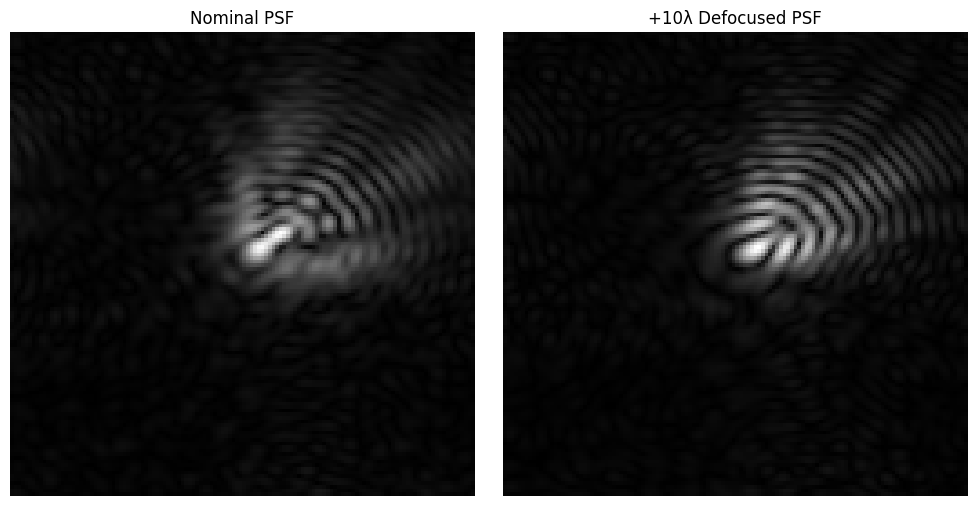

Global Defocus (Secondary Mirror): 10.0λ

Parameters with variation (to be predicted):
  secondary_piston: -14.704979
  secondary_tip: 56.281750
  secondary_tilt: -60.626943

----------------------------------------

Static parameters (not to be predicted):
  primary_1_piston: 0.000000
  primary_1_tip: 0.000000
  primary_1_tilt: 0.000000
  primary_2_piston: 0.000000
  primary_2_tip: 0.000000
  primary_2_tilt: 0.000000
  primary_3_piston: 0.000000
  primary_3_tip: 0.000000
  primary_3_tilt: 0.000000
  primary_4_piston: 0.000000
  primary_4_tip: 0.000000
  primary_4_tilt: 0.000000
  primary_5_piston: 0.000000
  primary_5_tip: 0.000000
  primary_5_tilt: 0.000000
  primary_6_piston: 0.000000
  primary_6_tip: 0.000000
  primary_6_tilt: 0.000000


In [9]:
visualize_psf_by_index(index=1, show_plots=True, transform_type='nth_root', n_root=2)